# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


## Authors

Joerg Kienitz for illustration of calibration using ANN

## Extract data

In [151]:
# location of the data files
import os
os.chdir("..\Data")

In [152]:
from io import StringIO
#import gzip
#import pandas as pd
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

dat = np.loadtxt('HestonTrainSet_ivol_long2_neg.txt')     # train on implied volatilities
NModelPar = 5                                    # number of model parameters 5 for Heston  
xx=dat[:,:NModelPar]                             # model parameters for training data
yy=dat[:,NModelPar:]                             # output data (prices/implied volatilities)
print(xx.shape)

strikes=np.array([0.5,0.60,0.7,0.8,0.9,1.00,1.1,1.2,1.3,1.4,1.5])                   # moneyness
maturities=np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])        # maturities
weights = np.array([0.1,0.1,0.1,10.0,10.0,10.0,10.0,10.0,0.5,0.5,0.5])
cw = np.ndarray.flatten(npm.repmat(weights,8,1))
NModelPar = 5

(100000, 5)


# Scale and Normalize data

In [164]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler


# we do not use this in the sequel
# now x_* hold the model parameters
# now y_+ hold the prices/implied volatilities
scalex = StandardScaler()
x_train_scaled = scalex.fit_transform(x_train)
x_test_scaled = scalex.transform(x_test)

scaley=  StandardScaler()
y_train_scaled = scaley.fit_transform(y_train)
y_test_scaled = scaley.transform(y_test)

In [258]:
# define suitable scalings for using with the nets
def xtransform(x_train,x_test):
    return [scalex.transform(x_train),scalex.transform(x_test)]

    
[x_train_scaled,x_test_scaled] = xtransform(x_train,x_test)

def xinversetransform(x):
    return scalex.inverse_transform(x)

In [171]:
# define suitable scalings for using with the nets
def ytransform(y_train,y_test):
    return [scaley.transform(y_train),scaley.transform(y_test)]

    
[y_train_scaled,y_test_scaled]=ytransform(y_train,y_test)

def yinversetransform(y):
    return scaley.inverse_transform(y)

In [105]:
#lower and upper bounds for the parameters; Heston: vInst, vLong, kappa, nu, rho
# we might wish to choose sets with dependent parameters, e.g. vInst and vLong are related
#       kappa and nu scale the variance of the stochastic variance by nu^2/kappa, etc.
# we might wish to restrict kappa since "kappa kills the skew"

ub=[0.5,0.5,1.0,1.0,0.0]
lb=[0.0025,0.0025,0.01,0.01,-0.9]

In [168]:
# scaling functions - manually
def myscale(x):
    res=np.zeros(NModelPar)
    for i in range(NModelPar):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
    return res

def myinverse(x):
    res=np.zeros(NModelPar)
    for i in range(NModelPar):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
    return res
    

In [169]:
x_train_transform = np.array([myscale(x) for x in x_train])
x_test_transform = np.array([myscale(x) for x in x_test])

# Create the Neural Network

In [170]:
# define the neural network
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

# initialize to corresponding data type
keras.backend.set_floatx('float64')

# network
input1 = keras.layers.Input(shape=(NModelPar,))             # input layer

x1 = keras.layers.Dense(60,activation = 'elu')(input1)      # hidden layer 1
x2 = keras.layers.Dense(60,activation = 'elu')(x1)          # hidden layer 2   
x3 = keras.layers.Dense(60,activation = 'elu')(x2)          # hidden layer 3 

x4=keras.layers.Dense(88,activation = 'linear')(x3)         # needs to be adjusted wrt output size

# set up the model
modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

# weight that is multiplied to the values at the corresponding strikes
w = K.constant(cw) 


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                360       
_________________________________________________________________
dense_10 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_11 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_12 (Dense)             (None, 88)                5368      
Total params: 13,048
Trainable params: 13,048
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [109]:
## for using early stopping
#from keras.callbacks import Callback
#class EarlyStoppingByLossVal(Callback):
#    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
#        super(Callback, self).__init__()
#        self.monitor = monitor
#        self.value = value
#        self.verbose = verbose
#
#    def on_epoch_end(self, epoch, logs={}):
#        current = logs.get(self.monitor)
#        if current is None:
#            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
#
#        if current < self.value:
#            if self.verbose > 0:
#                print("Epoch %05d: early stopping THR" % epoch)
#            self.model.stop_training = True
#            
#            
#callbacks = [
#    EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
#    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
#    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
#]


# keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
## monitor: quantity to be monitored. min_delta: 
##     minimum change in the monitored quantity to qualify as an improvement, 
##     i.e. an absolute change of less than min_delta, will count as no improvement. 
## patience: number of epochs with no improvement after which training will be stopped
## verbose: verbosity mode. mode: one of {auto, min, max}. 
##     In min mode, training will stop when the quantity monitored has stopped decreasing; 
##     in max mode it will stop when the quantity monitored has stopped increasing; 
##     in auto mode, the direction is automatically inferred from the name of the monitored quantity. 
## baseline: Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show 
##  improvement over the baseline. 
## restore_best_weights: whether to restore model weights from the epoch with the best value of the monitored quantity. 
##     If False, the model weights obtained at the last step of training are used.

In [110]:
# parameters we wish to penalize
parameters = np.zeros(len(y_train_transform))
for index in range(len(y_train_transform)):
    parameters[index] = y_train_transform[index][3]
    
np.shape(parameters)

In [112]:
np.shape(x_train_transform)

(85000, 88)

In [172]:
# define the objective function and do the compilation and fitting
# Heston: least squares with weights w
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(w*K.square(y_pred - y_true)))

#def custom_loss_wrapper(parameters):
#    def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(w*K.square(y_pred - y_true))) + 0.01 * K.mean(K.square(parameters)) 
#    return root_mean_squared_error

# compile the model for training using the objective function just defined
# standard
#modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")        # weighted rmse, optimizer adam
# addditional parameters
modelGEN.compile(loss = custom_loss_wrapper(x_train_transform), optimizer = "adam")        # weighted rmse, optimizer adam

# the model takes y_train_transform as input (the model smile)
# and it learns the model parameters, the output or predictions
history = modelGEN.fit(x_train_scaled, y_train_scaled, batch_size=32,validation_data = (x_test_scaled,y_test_scaled),epochs = 50, verbose = True,shuffle=1)#,callbacks=[earlystop])

Train on 85000 samples, validate on 15000 samples
Epoch 1/50
85000/85000 [==============================] - 3s 39us/step - loss: 0.1531 - val_loss: 0.1009
Epoch 2/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0664 - val_loss: 0.0504
Epoch 3/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0525 - val_loss: 0.0542
Epoch 4/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0455 - val_loss: 0.0393
Epoch 5/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0422 - val_loss: 0.0384
Epoch 6/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0385 - val_loss: 0.0327
Epoch 7/50
85000/85000 [==============================] - 2s 28us/step - loss: 0.0366 - val_loss: 0.0633
Epoch 8/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0366 - val_loss: 0.0398
Epoch 9/50
85000/85000 [==============================] - 2s 27us/step - loss: 0.0346 - val_loss: 0.0465
Epoch

dict_keys(['val_loss', 'loss'])


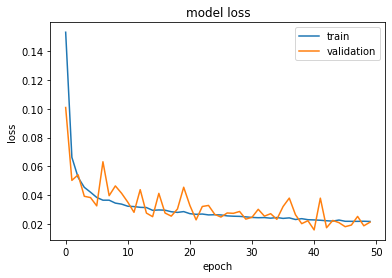

In [173]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for loss and plot on training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Store/Load optimal NN parameteres

In [ ]:
os.chdir("..\Weights")

In [174]:
modelGEN.save_weights('HestonNNWeights_ivol.h5')

In [175]:
modelGEN.load_weights('HestonNNWeights_ivol.h5')

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [176]:
# This puts the weights from the network into the NNParameters array
# The array is used for the numpy implementation of the neural net
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

In [177]:
# this defines a FNN using straight numpy to gain time advantages since numpy is faster!
NumLayers=3
def elu(x):
    #Careful function overwrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(NModelPar)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

# Numpy gives 20 fold speed up

In [178]:
# %timeit NeuralNetwork(y_train_transform[0])

In [179]:
# %timeit modelGEN.predict(y_train_transform[0].reshape(1,NModelPar))[0]

In [180]:
# %timeit NeuralNetworkGradient(y_train_transform[0])

In [181]:
# NeuralNetwork(y_train_transform[8])

In [182]:
# modelGEN.predict(y_train_transform[8].reshape(1,NModelPar))[0]

# Compute Prices / Implied vol relative errors on Test set

In [183]:
import numpy as np
import csv

S0=1.0
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])     # needs to be adjusted if other maturities are used

C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


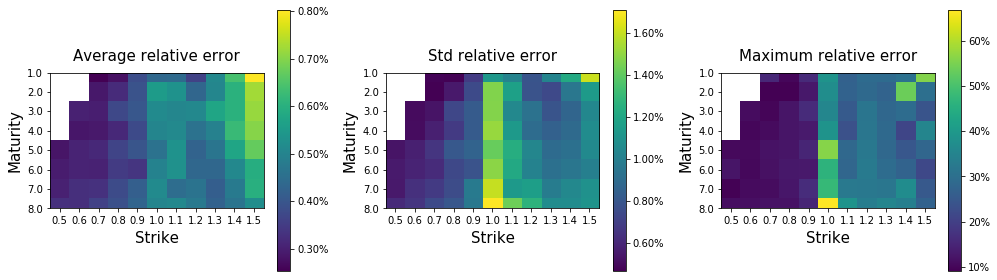

In [203]:
os.chdir("..\Pictures")

##### AVERAGE VALUES #######
y_sample = yinversetransform(y_test_scaled)                    # the realizations
x_sample = x_test_scaled # the parameters

Scaling_0 = 100.0

prediction = [yinversetransform(modelGEN.predict(x_sample[i].reshape(1,NModelPar))[0]) for i in range(len(x_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(Scaling_0*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = Scaling_0*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = Scaling_0*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()

In [204]:
index = 3098
#prediction = [xinversetransform(modelGEN.predict(y_sample[i].reshape(1,NModelPar))[0]) for i in range(index:index)]
#X_sample[index]
print(yinversetransform(modelGEN.predict(x_sample[index].reshape(1,NModelPar))))
print(y_sample[index])

[[0.68700168 0.6571596  0.631039   0.606624   0.58411002 0.5651678
  0.54702805 0.53187698 0.51900769 0.507136   0.49610285 0.63771496
  0.61278735 0.5915243  0.57268077 0.55575271 0.54150736 0.52906997
  0.51821226 0.50903617 0.50002445 0.49190614 0.60814878 0.58865333
  0.57144478 0.55652248 0.54361993 0.5330634  0.52321688 0.51448398
  0.50775958 0.50062946 0.49375521 0.5909482  0.57491661 0.56065913
  0.54859956 0.53863837 0.52961675 0.52138382 0.5144092  0.50844824
  0.5028012  0.49744996 0.58023973 0.56611679 0.5544678  0.54419927
  0.53587764 0.52835762 0.52129153 0.51479912 0.50960504 0.50529563
  0.50070652 0.57271331 0.56044351 0.55046176 0.54157113 0.53423139
  0.52774057 0.52166004 0.51574421 0.51108086 0.50720006 0.50321771
  0.56710662 0.55639926 0.5474944  0.53984683 0.53363414 0.52775984
  0.52182492 0.51641391 0.51244045 0.50899722 0.50571531 0.56301722
  0.55338931 0.54547753 0.53862281 0.53267594 0.52776913 0.52238185
  0.51768797 0.51356028 0.51021133 0.50725573]]
[

# Plot sample Prices/Smiles

C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


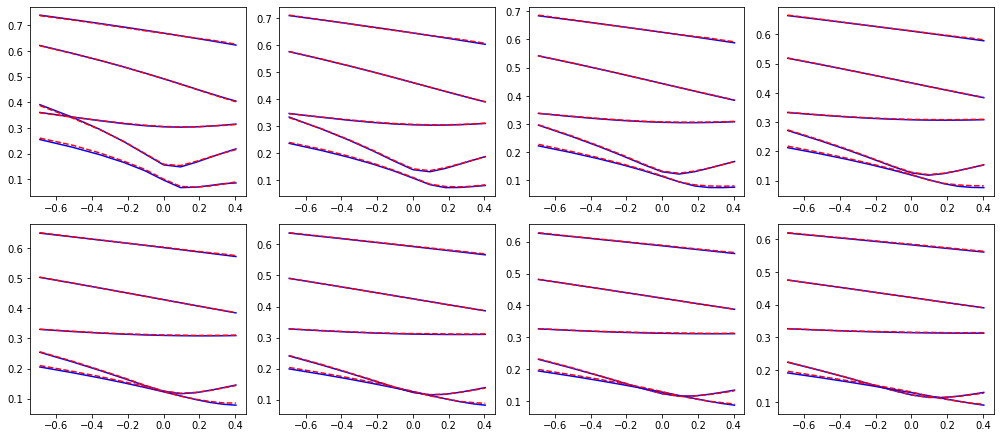

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy

S0 = 1.0
NStart = 3299
for jj in range(5):
    x_sample = x_test_scaled[NStart+jj]
    y_sample = yinversetransform(y_test_scaled[NStart+jj])

    prediction=yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar)))
    plt.figure(1,figsize=(14,12))
    
    for i in range(maturities_dim):
        plt.subplot(4,4,i+1)
        np.shape(prediction)
        np.shape(y_sample)
        plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(np.log(strikes/S0),prediction[0][i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    plt.tight_layout()
    

plt.show()

C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


inf 0.1328327370753275 194 0 565 1
abs 0.0025 a diff 0.1328327370753275 -0.1303327370753275 r diff -52.133094830131
rel 0.006281142518771255 0.11265558995381897 a diff -0.10637444743504772 r diff -16.93552520375818
0.1328327370753275 inf
index 194 0


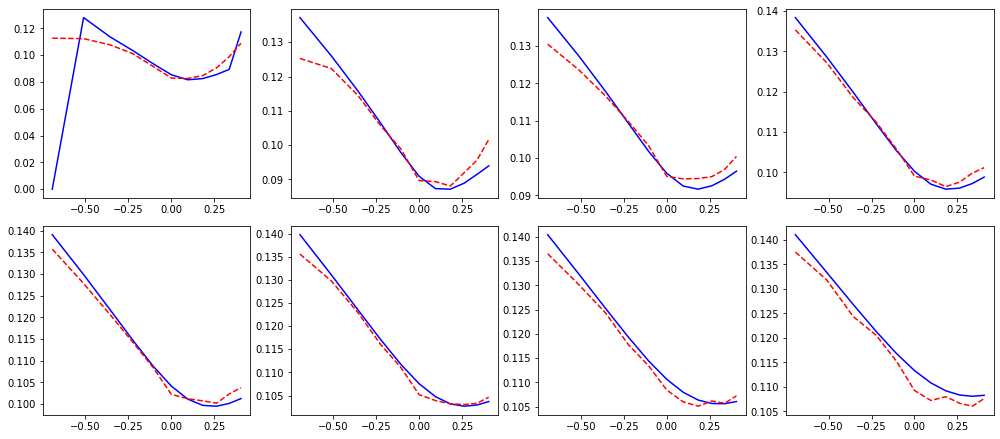

In [226]:
# find the worst cases for absolute and relative differences; calculate and plot
S0=1.
NStart = 0
mx = 0.0
rval = 0.0
aval = 0.0

absdiffval = 0.0
reldiffval =  0.0

for jj in range(5000):
    x_sample = x_test_scaled[NStart+jj]                       # get the parameters to make prediction
    y_sample = yinversetransform(y_test_scaled[NStart+jj])    # vol values to be predicted
    
    predictiony=yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0]) # prediction using x values
    absdiffvall = absdiffval                                 # set candidate absdiffvall
    reldiffvall = reldiffval                                 # set candidate reldiffval
    
    absdiff = np.absolute(y_sample - predictiony)            # absolute difference for this sample
    reldiff = np.divide(absdiff,y_sample)                    # relative difference for this sample
    
    absdiffval = max(np.amax(absdiff),absdiffval)            # compare
    reldiffval = max(np.amax(reldiff),reldiffval)            # compare
    if absdiffval > absdiffvall:
        ind = np.unravel_index(np.argmax(absdiff, axis=None), absdiff.shape)
    if reldiffval > reldiffvall:
        ind = np.unravel_index(np.argmax(reldiff, axis=None), reldiff.shape)
 
    for kk in range(0,87):    # iterate over all volatilities
        rvall = rval
        avall = aval
        val = abs(y_sample[kk]-predictiony[kk])
        rval = max(abs(y_sample[kk]-predictiony[kk])/y_sample[kk], rval)
        aval = max(abs(y_sample[kk] - predictiony[kk]),aval)
        if rval > rvall:
            indexj = jj
            indexk = kk
        if aval > avall:
            indexjj = jj
            indexkk = kk
    
print(rval, aval, indexj, indexk, indexjj, indexkk)

xx_sample_test = x_test_scaled[indexj]
yy_sample_test = yinversetransform(y_test_scaled[indexj])

# predict the values on the test data
prediction_test = yinversetransform(modelGEN.predict(xx_sample_test.reshape(1,NModelPar))[0])
# now we plot the outcome for prediction using yy_sample_test against true values xx_sample_test
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),yy_sample_test[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction_test[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
plt.tight_layout()

predictiony = yinversetransform(modelGEN.predict(x_test_scaled[indexjj].reshape(1,NModelPar))[0])
xvalx = x_test[indexjj,indexkk]
xvaly = predictiony[indexkk]
print('abs',xvalx, 'a diff', xvaly, xvalx-xvaly, 'r diff', (xvalx-xvaly)/xvalx)
predictiony = yinversetransform(modelGEN.predict(x_test_scaled[indexj].reshape(1,NModelPar))[0])
xvalx = x_test[indexj,indexk]
xvaly = predictiony[indexk]
print('rel',xvalx, xvaly, 'a diff', xvalx-xvaly, 'r diff', (xvalx-xvaly)/xvalx)
print(absdiffval, reldiffval)
print('index',indexj,indexk)

In [391]:
os.chdir("..\Data")
# now we use the Net directly on some new generated test data
# the data has the same structure as the data for training
TestData=np.loadtxt("surfacesFromNNHeston_ivol_long2_neg.txt")
xx_sample = scalex.transform(TestData[:,:NModelPar])                       # the model parameters
yy_sample = TestData[:,NModelPar:]                       # the prices/ivols corresponding to the parameters


In [392]:
np.shape(xx_sample)

(5000, 5)

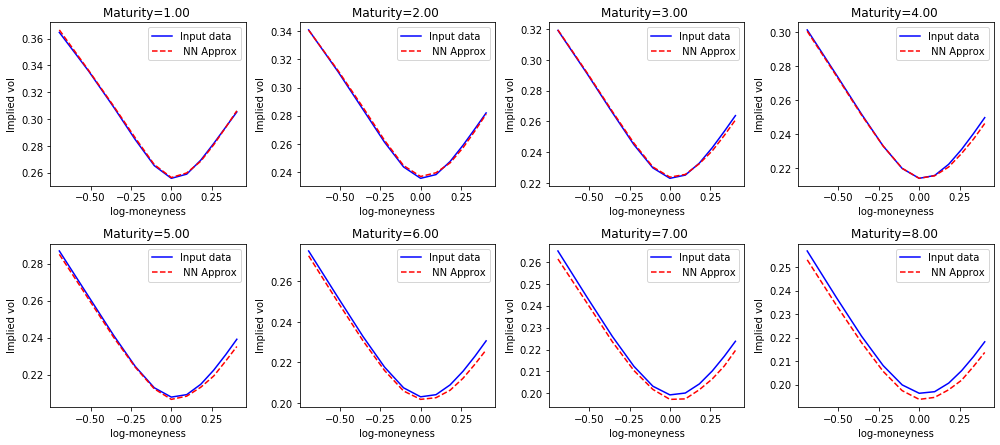

In [393]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
S0=1.

sample_ind = 4523 #4523
x_sample = xx_sample[sample_ind]
y_sample = yy_sample[sample_ind]
#print(scale.inverse_transform(y_sample))
#print(myinverse(y_sample))

prediction = yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0])
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()


# Use gradient methods for optimization

In [243]:
os.chdir("..\Data")
# load test data
SurfacesCalib = np.loadtxt("surfacesFromNNHeston_ivol_long2_neg.txt")
#SurfacesCalib=np.loadtxt("surfacesFromNNHeston_ivol.txt")

SurfacesCalib.shape



(5000, 93)

In [312]:
# Unseen data
SurfacesCalibTarget = SurfacesCalib[:,:NModelPar]    # SurfacesCalib[:,:NModelPar] - the target parameters from the data set
SurfacesCalibVal = SurfacesCalib[:,NModelPar:]       # the results (prices/vol) are stored in this variable

SurfacesCalibTarget_scaled = scalex.transform(SurfacesCalibTarget)
SurfacesCalibVal_scaled = scaley.transform(SurfacesCalibVal) #scale2.transform(SurfacesCalibVal)
#SurfacesCalibParams = SurfacesCalib[:,:NModelPar]                 # ???

yy_test = SurfacesCalib #SurfacesCalib[:,:NModelPar]
yy_test_transform = np.array([myscale(y) for y in yy_test])


In [247]:
# may we introduce weights for the corresponding points!?
def CostFunc(x,indexs):
    return np.sum(cw*np.power((yinversetransform(NeuralNetwork(x))-SurfacesCalibVal[indexs]),2))
def Jacobian(x,indexs):
    return 2*np.sum(cw*(yinversetransform(NeuralNetwork(x))-SurfacesCalibVal[indexs])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,indexs):
    return cw*(yinversetransform(NeuralNetwork(x))-SurfacesCalibVal[indexs])
def JacobianLS(x,indexs):
    return NeuralNetworkGradient(x).T

In [326]:
import time
import scipy
NOpt = 4;     # number of Optimizers
NRuns = 5000;   # Number of runs
Approx=[]
Timing=[]

solutions=np.zeros([NOpt,NModelPar])          # stores the solutions from optimization   
times=np.zeros(NOpt)                          # just stores the times 
init=np.zeros(NModelPar)                      # initialize @ zero but could be other starting values, e.g. smart parameters

for i in range(NRuns):
    disp=str(i+1)+"/"+str(NRuns)
    print (disp,end="\r")
    #L-BFGS-B
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[0,:] = xinversetransform(I.x) #myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[1,:] = xinversetransform(I.x) #myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.clock()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.clock()
    solutions[2,:] = xinversetransform(I.x)  #myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.clock()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.clock()
    solutions[3,:] = xinversetransform(I.x) #myinverse(I.x)
    times[3]=end-start
    #I=scipy.optimize.minimize(costfunc,x0=init,method='COBYLA',options={"maxiter":2000})
    #print(I)
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    #print("Approx ",scale.inverse_transform(I.x))
    #print("True: ",scale.inverse_transform(y_sample))

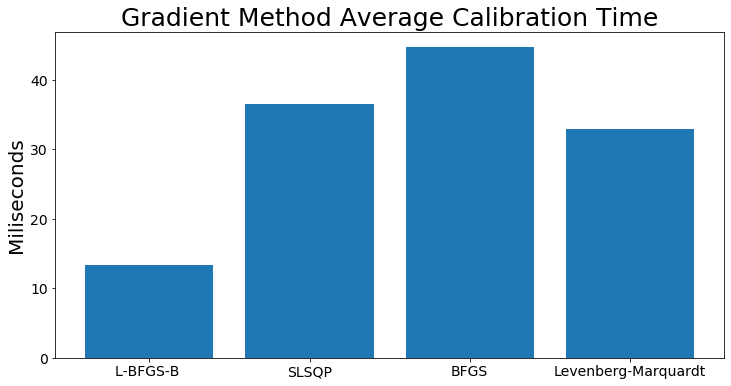

In [327]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the  Optimal parameters

In [328]:
# choose optimizer 0 -> L-BFGS-B, 1 -> SLSQP, 2-> BFGS, 3-> Levenberg 
NOpti = 1
OptParameters=[Approx[i][NOpti] for i in range(len(Approx))]
np.savetxt("NNParametersHeston_ivol.txt",OptParameters)  

# Calibration Errors 

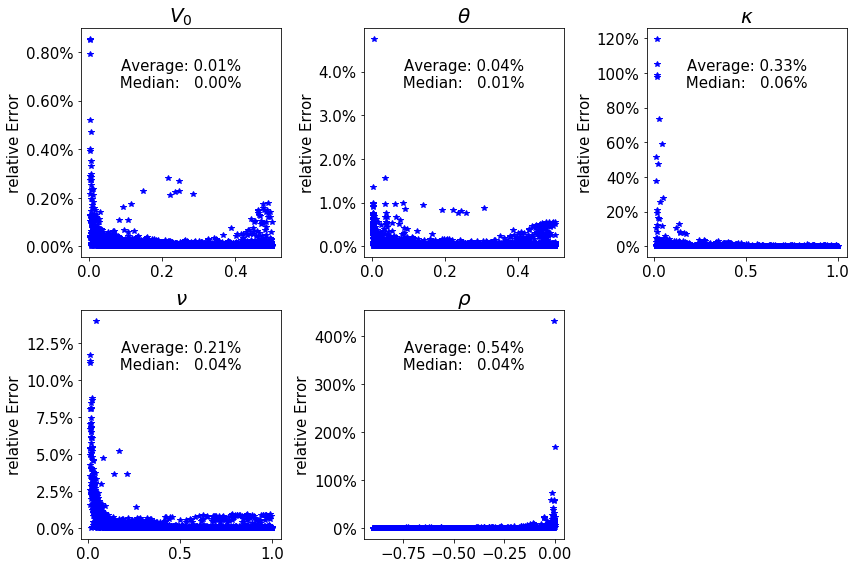

In [342]:
os.chdir("..\Pictures")
titles=["$V_0$", "$\\theta$", "$\\kappa$","$\\nu$","$\\rho$"]
Scaling = 1.0

average=np.zeros([5,NRuns])
fig=plt.figure(figsize=(12,8))
for u in range(NModelPar):
    ax=plt.subplot(2,3,u+1)
    for i in range(NRuns):        
        y=SurfacesCalibTarget[i][u]
        plt.plot(y,Scaling*np.abs(OptParameters[i][u]-y)/np.abs(y),'b*')      
        average[u,i]=np.abs(OptParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(Scaling*average[u,:]),np.quantile(Scaling*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

plt.tight_layout()
plt.savefig('HestonParameterRelativeErrors_long2_neg_ivol.png', dpi=300)
plt.show()

In [330]:
os.chdir("..\Data")
Approx=np.loadtxt("NNParametersHeston_ivol.txt")

# Load corresponding smile generated by Integration Methods

In [365]:
# Compute the parameters from unseen data and analyze
fullprediction = yinversetransform(modelGEN.predict(SurfacesCalibTarget_scaled)) # predicted surface

rmse = np.sqrt(np.mean(np.power(SurfacesCalibVal-fullprediction,2),axis=1))
ind=~(rmse == np.inf)
rmse = rmse[ind]

absme = np.abs(np.mean(SurfacesCalibVal-fullprediction,axis=1))
ind=~(absme == np.inf)
absme = absme[ind]

C:\Users\KienitzJoerg\Anaconda3\envs\MachineLearning36_T2\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


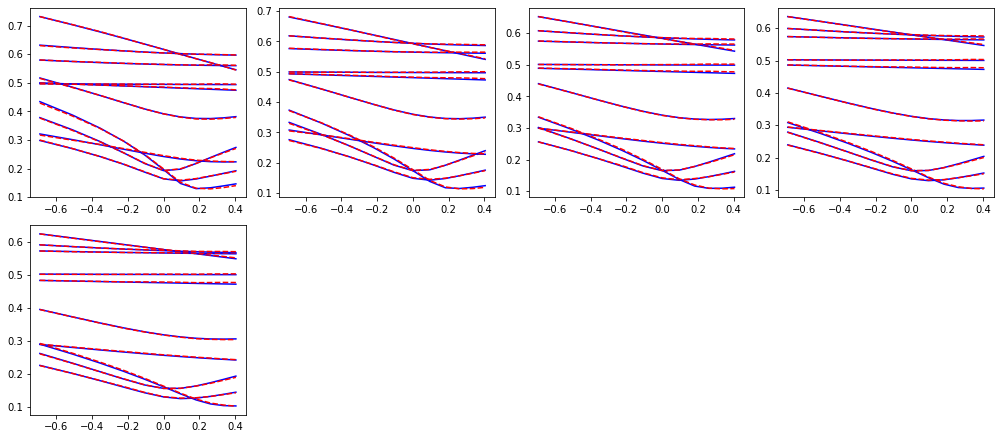

In [344]:
# show performance on unseen data for data
S0=1.
NStart = 5
for jj in range(10):
    x_sample = SurfacesCalibTarget_scaled[NStart+jj]
    y_sample = SurfacesCalibVal[NStart+jj]

    prediction = yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0])
   # prediction
    plt.figure(1,figsize=(14,12))
    for i in range(5):
        plt.subplot(4,4,i+1)
        plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
       # plt.plot(np.log(strikes/S0),XT_sample[i*strikes_dim:(i+1)*strikes_dim],'--k',label="Target data")
        plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
    plt.tight_layout()
    
    

plt.show()

rms max 0.0036705493493122483  at index 49 ; rms min 0.0006171576757550339  at index 15
[ 1.36104467e-02  8.56093769e-03  3.88436110e-03  2.47749452e-03
 -1.73840347e-03 -1.28103480e-03  7.04994348e-04  2.54315484e-03
 -1.93759786e-03 -1.78175442e-04 -2.01072452e-03  1.47447881e-02
  5.36239951e-03  5.48947282e-03  2.14285455e-04 -1.09458277e-03
 -3.56999071e-03 -1.31366908e-03 -6.56259371e-04  6.33876369e-04
  3.93575510e-04 -2.45115397e-04  7.42075624e-03  5.56056296e-03
  2.37999596e-03 -7.13792840e-04 -1.15317136e-03 -3.83539548e-03
 -1.58098124e-03  1.29929078e-03  1.00941109e-03 -4.26733547e-04
 -1.16272382e-03  4.86528348e-03  4.59330188e-03  1.44673254e-04
  4.13915186e-04 -2.61276798e-03 -4.49659690e-03 -2.50296890e-03
 -1.50671005e-03 -1.80371081e-04  3.23562324e-04  2.21215929e-05
  5.59763946e-03  5.73989996e-04 -2.40616754e-04 -2.11863258e-03
 -3.69272588e-03 -4.95101657e-03 -3.20484908e-03 -1.50878752e-03
 -6.43530842e-04  6.64318231e-04  8.21058620e-04  2.22183353e-03
  

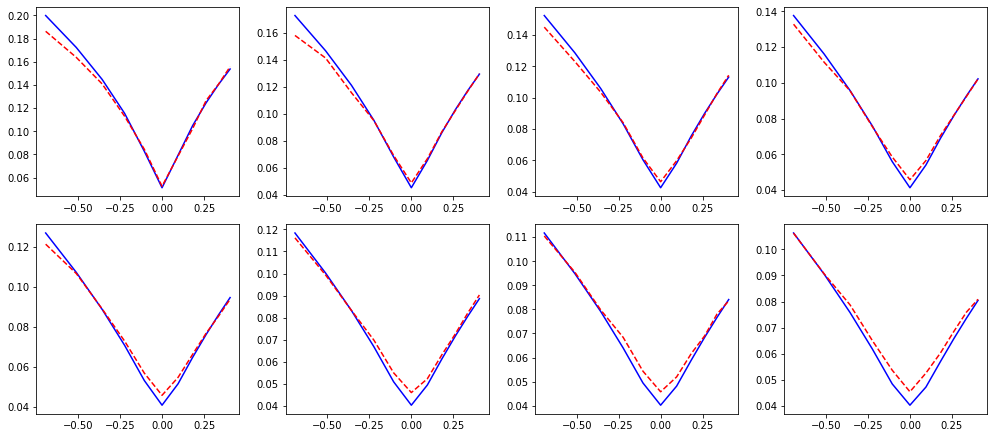

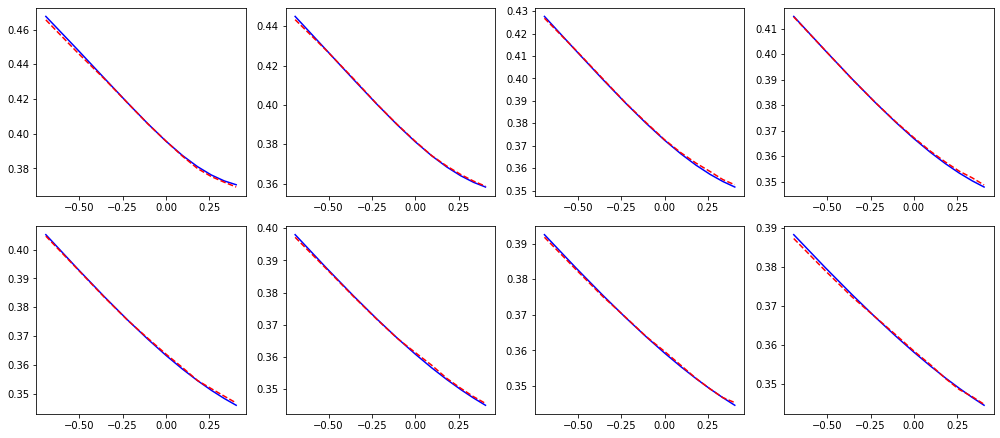

In [345]:
rmserrmax = 0.0
rmserrmin = 1000.0

for jj in range(50):
    rmserrn= np.sqrt(np.mean(np.power(fullprediction[jj,:]-SurfacesCalibVal[jj,:],2)))
    if rmserrn > rmserrmax:
        rmserrmax = rmserrn
        maxindex = jj
    if rmserrn < rmserrmin:
        rmserrmin = rmserrn
        minindex = jj
        

print('rms max', rmserrmax,' at index', maxindex, '; rms min', rmserrmin, ' at index', minindex)

print(SurfacesCalibVal[maxindex]-fullprediction[maxindex])

print(SurfacesCalibVal[minindex]-fullprediction[minindex])

S0=1.
x_sample = SurfacesCalibTarget_scaled[maxindex]
#X_sample = SurfacesCalibTarget[minindex]
y_sample = SurfacesCalibVal[maxindex]

prediction = yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0])
# prediction
plt.figure(1,figsize=(14,12))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

plt.tight_layout()  

plt.show()


x_sample = SurfacesCalibTarget_scaled[minindex]
#X_sample = SurfacesCalibTarget[minindex]
y_sample = SurfacesCalibVal[minindex]

prediction = yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0])
# prediction
plt.figure(1,figsize=(14,12))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
plt.tight_layout()  

plt.show()

0.06105170424176243 0.30541133137534127 0.06105170424176243 99 0 99 0
abs x 0.2640207065963909 abs y 0.5738173136684522 abs diff -0.30979660707206136 rel diff -1.1733799635103932
rel 0.2640207065963909 0.5738173136684522 abs diff -0.30979660707206136 rel diff -1.1733799635103932


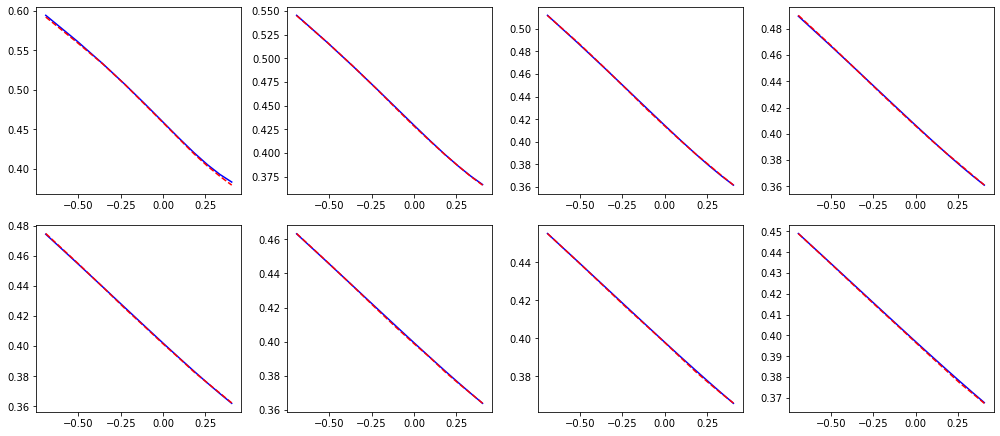

In [346]:
# find the worst cases for absolute and relative differences; calculate and plot
S0=1.
NStart = 0
mval = 0.0
mx = 0.0
rval = 0.0
aval = 0.0

for jj in range(500):
    x_sample = SurfacesCalibTarget_scaled[NStart+jj]
    y_sample = SurfacesCalibVal[NStart+jj]
    predictiony = yinversetransform(modelGEN.predict(x_sample.reshape(1,NModelPar))[0])

    for kk in range(0,87):
        rvall = rval
        avall = aval
        val = abs(y_sample[kk]-predictiony[kk])
        rval = max(abs(y_sample[kk]-predictiony[kk])/X_sample[kk], rval)
        aval = max(abs(y_sample[kk] - predictiony[kk]),aval)
        if rval > rvall:
            indexj = jj
            indexk = kk
        if aval > avall:
            indexjj = jj
            indexkk = kk
        mval = max(val,mval)

print(mval, rval, aval, indexj, indexk, indexjj, indexkk)

xx_sample_test = x_test_scaled[indexj]
yy_sample_test = y_test[indexj]

# predict the values on the test data
prediction_test = yinversetransform(modelGEN.predict(xx_sample_test.reshape(1,NModelPar))[0])
# now we plot the outcome for prediction using yy_sample_test against true values xx_sample_test
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),yy_sample_test[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction_test[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")
plt.tight_layout()

predictiony = yinversetransform(modelGEN.predict(x_test_transform[indexjj].reshape(1,NModelPar))[0])
xvalx = x_test[indexjj,indexkk]
xvaly = predictiony[indexkk]
print('abs x',xvalx, 'abs y', xvaly, 'abs diff', xvalx-xvaly, 'rel diff', (xvalx-xvaly)/xvalx)

predictiony = yinversetransform(modelGEN.predict(x_test_transform[indexj].reshape(1,NModelPar))[0])
xvalx = x_test[indexj,indexk]
xvaly = predictiony[indexk]
print('rel',xvalx, xvaly, 'abs diff', xvalx-xvaly, 'rel diff', (xvalx-xvaly)/xvalx)

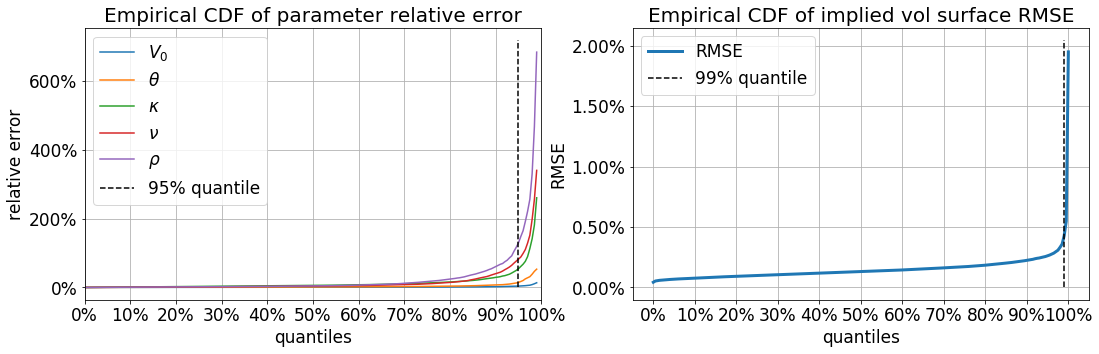

In [388]:
os.chdir("..\Pictures")
# illustration on unseen data
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)
Scaling = 100.0

ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(5):
    p=plt.plot(Scaling * q,Scaling * np.quantile(average[u,:],q),label=titles[u])
    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(Scaling * np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(Scaling*q,np.quantile(Scaling*rmse,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(Scaling*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('HestonErrorCDF_rmse.png', dpi=300)
plt.show()



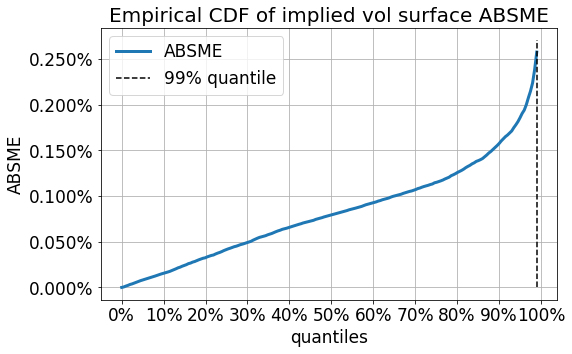

In [389]:
# illustration on unseen data
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)
Scaling = 100.0

ax = plt.gca()
q=np.linspace(0,0.99,200)

p=plt.plot(Scaling*q,np.quantile(Scaling*absme,q),linewidth=3,label="ABSME")
ymin, ymax = ax.get_ylim()
plt.plot(Scaling*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface ABSME",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("ABSME",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('HestonErrorCDF_absme.png', dpi=300)
plt.show()

There you have it. Problem solved! … You would think. The model now nicely compiles, but when you try to load a saved version of the model another problem pops up.
ValueError: Unknown loss function:loss
Some more digging around and I also found the solution for this. The problem is that the model has saved a loss function with the name loss, because that is the name of the function that is actually returned by the asymmetric_loss function, but it can’t find that function when it loads the model, because the loss function is embedded in the asymmetric_loss function. So, you need to inform the load_model function of this through the custom_objects dictionary.
model = load_model('model.h5', 
                   custom_objects={'loss': asymmetric_loss(alpha)})
Now everything runs smoothly.